In [1]:
%matplotlib inline

In [2]:
# import libraries 

import pandas as pd

# this is here to shut off some annoying warnings from pandas
pd.options.mode.chained_assignment = None

# matplotlib is one of the main plotting libraries we're going to use
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# the other plotting library is seaborn - we'll use both during the class

# import seaborn as sns

# numpy and scipy are for handling numerical and scientific data

import numpy as np
import scipy as sp

#import statsmodels.formula.api as smf # basic statistical modeling

from scipy.stats.stats import pearsonr 

import os

import scipy
from scipy import stats
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean
from scipy.stats import linregress


#from pandas.tools.plotting import scatter_matrix

In [4]:
# setup

datafile = "data/barton/Barton_combined.txt"
ye = pd.read_csv(datafile)   # the sep='\t' tells pandas that it is a tab separated file
ye = ye.set_index('Gene')

exps = {}
exps['wt'] = [e for e in ye.columns if e.startswith('WT')] 
exps['mut'] = [e for e in ye.columns if e.startswith('Snf2')] 
exps['all'] = exps['wt'] + exps['mut']

for cycles in range(0,10):
    ye['all_gmean']  = gmean(ye[exps['all']].replace(0,np.nan).values,axis=1)
    
    df = ye[ye['all_gmean'] > 10]

    for c in exps['all']:
        norm = np.median(df[c]/df['all_gmean'])
        ye[c] = ye[c] / norm
        
# computer row stats

for d in ['all','wt','mut']:
    ye[d + '_mean']   = ye[exps[d]].mean(axis=1)
    ye[d + '_median'] = ye[exps[d]].median(axis=1)
    ye[d + '_var']    = ye[exps[d]].var(axis=1)
    ye[d + '_std']    = ye[exps[d]].std(axis=1)
    ye[d + '_gmean']  = gmean(ye[exps[d]].replace(0,np.nan).values,axis=1)
    
ye['med_ratio'] =  (ye['mut_median'] / ye['wt_median']).replace(np.inf,np.nan).replace(-np.inf,np.nan)
ye['true_de'] = np.log(ye['med_ratio'].replace(0,np.nan))/np.log(2)
ye['abs_true_de'] = np.abs(ye['true_de'])    

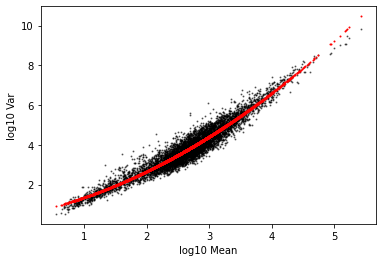

In [5]:
yew = ye[exps['wt']]
yew = yew[yew.min(axis=1) > 0]
x = np.log10(np.mean(yew,axis=1))
y = np.log10(np.var(yew,axis=1))
plt.scatter(x,y,s=1,c='black',alpha=.5)
plt.xlabel('log10 Mean')
plt.ylabel('log10 Var')

pf = np.polyfit(x,y, 2, rcond=None, full=False, w=None, cov=False)
var_from_mean_pf = np.poly1d(pf)

plt.scatter(x,var_from_mean_pf(x),c='red',s=1)

In [11]:
def var_from_mean(mu):
    return np.power(10,var_from_mean_pf(np.log10(mu)))

## How do we test for differential expression?

There are many ways of formulating this question, and there is no simple answer, but we'll explore some ideas here. For starters, let's use a standard t-test.

A t-test compares the means of two distributions and asks what the probability is that two samples with those means came from the same distribution by testing this as the null hypothesis.  

It uses the t-statistic, defined as:

$\huge t = { {M_1 - M_2}\over{\sigma\over{\sqrt{n_{\small1}+n_{\small2}}}}}$

where

$M_1$ and $M_2$ are the sample means, $\sigma$ is the standard deviation and $n_1$ and $n_2$ are the sample sizes.  

I'm sure you've all done t-tests, but it's useful just to see what we're doing here.

(array([  6.,  21.,  84., 181., 254., 235., 137.,  63.,  15.,   4.]),
 array([-565.73859724, -239.18179011,   87.37501703,  413.93182416,
         740.4886313 , 1067.04543844, 1393.60224557, 1720.15905271,
        2046.71585985, 2373.27266698, 2699.82947412]),
 <BarContainer object of 10 artists>)

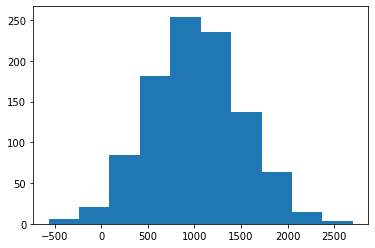

In [37]:
# let's sample from a normal distribution

mu = 1000
sigma = 500
s = np.random.normal(mu, sigma, 1000)

plt.hist(s)

In [26]:
# now define a t-stat

def tstat (s1,s2):
    m1 = np.mean(s1)
    m2 = np.mean(s2)
    sd = np.std(np.concatenate((s1,s2)))
    tstat = (m1 - m2) / (sd / np.sqrt(len(s1)+len(s2)))
    return tstat

In [38]:
mu = 1000
sigma = 500
sample_size = 3
s1 = np.random.normal(mu, sigma, sample_size)
s2 = np.random.normal(mu, sigma, sample_size)
tstat(s1,s2)

-1.9960067700673942

In [ ]:
# now let's look at the distribution of the t-stat

mu = 1000
sigma = 500
sample_size = 3

tstats = []
for trials in range(0,10000):
    s1 = np.random.normal(mu, sigma, sample_size)
    s2 = np.random.normal(mu, sigma, sample_size)
    tstats.append(tstat(s1,s2))
    
plt.hist(tstats,color='blue',alpha=.5,density=True)

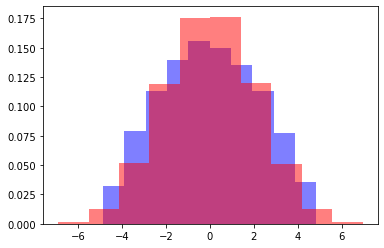

In [48]:
# now let's compare 

mu = 1000
sigma = 500
sample_size = 3

tstats = []
for trials in range(0,10000):
    s1 = np.random.normal(mu, sigma, sample_size)
    s2 = np.random.normal(mu, sigma, sample_size)
    tstats.append(tstat(s1,s2))
    
h1 = plt.hist(tstats,color='blue',alpha=.5,density=True)


mu = 1000
sigma = 500
sample_size = 10

tstats = []
for trials in range(0,10000):
    s1 = np.random.normal(mu, sigma, sample_size)
    s2 = np.random.normal(mu, sigma, sample_size)
    tstats.append(tstat(s1,s2))
    
h2 = plt.hist(tstats,color='red',alpha=.5,density=True)

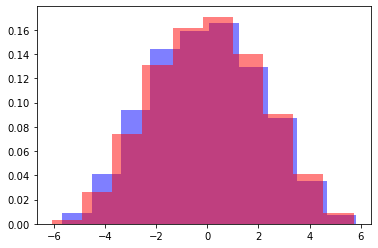

In [49]:
# now let's compare 

mu = 1000
sigma = 500
sample_size = 5

tstats = []
for trials in range(0,10000):
    s1 = np.random.normal(mu, sigma, sample_size)
    s2 = np.random.normal(mu, sigma, sample_size)
    tstats.append(tstat(s1,s2))
    
h1 = plt.hist(tstats,color='blue',alpha=.5,density=True)


mu = 1000
sigma = 100
sample_size = 5

tstats = []
for trials in range(0,10000):
    s1 = np.random.normal(mu, sigma, sample_size)
    s2 = np.random.normal(mu, sigma, sample_size)
    tstats.append(tstat(s1,s2))
    
h2 = plt.hist(tstats,color='red',alpha=.5,density=True)

In [56]:
# let's look at behavior of samples

mu = 1000
sigma = 500

results = []

for sample_size in range(5,100,5):
    for trials in range(0,100):
        s1 = np.random.normal(mu, sigma, sample_size)
        s2 = np.random.normal(mu, sigma, sample_size)
        sd = np.std(np.concatenate((s1,s2)))
        ts = tstat(s1,s2)
        results.append([sample_size,sd,ts])
        
results = np.array(results)

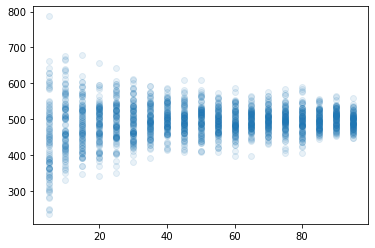

In [57]:
plt.scatter(results[:,0],results[:,1],alpha=.1)

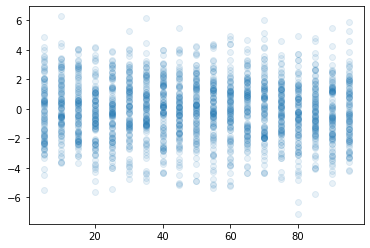

In [58]:
plt.scatter(results[:,0],results[:,2],alpha=.1)

In [60]:
# let's look at behavior of samples

mu = 1000
sample_size = 5

results = []

for sigma in range(100,1000,100):
    for trials in range(0,100):
        s1 = np.random.normal(mu, sigma, sample_size)
        s2 = np.random.normal(mu, sigma, sample_size)
        sd = np.std(np.concatenate((s1,s2)))
        ts = tstat(s1,s2)
        results.append([sigma,sd,ts])
        
results = np.array(results)

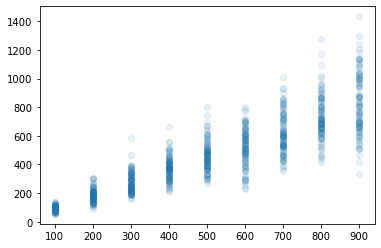

In [61]:
plt.scatter(results[:,0],results[:,1],alpha=.1)

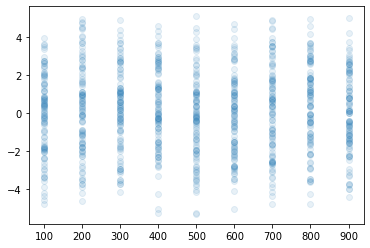

In [62]:
plt.scatter(results[:,0],results[:,2],alpha=.1)

## What happens if we know the variance?

If we know the variance in advance, we don't have to use a t-statistic. We can instead use some simple facts about normal distributions.  

First, if we have a normal distribution with mean $\mu$ and standard deviation $\sigma$ and we repeatedly sample $n$ times from the distribution, the distribution of sample means is a normal distribution with mean $\mu$ and standard deviation $\sigma\over{\sqrt{n}}$.

In [108]:
mu = 1000
sigma = 500

for sample_size in range(3,20):
    means = []
    for trials in range(0,10000):
        s = np.random.normal(mu, sigma, sample_size)
        means.append(np.mean(s))
    
    print ("%d %d %d %d" %(sample_size,np.mean(means),np.std(means),sigma/np.sqrt(sample_size)))

3 1001 284 288
4 1002 251 250
5 999 225 223
6 1000 202 204
7 999 190 188
8 1003 175 176
9 1000 165 166
10 999 156 158
11 1002 152 150
12 1000 143 144
13 1002 138 138
14 1000 134 133
15 1000 128 129
16 1000 124 125
17 1000 121 121
18 1000 118 117
19 998 115 114


What about the difference of means of two samples drawn from same distribution with mean $\mu$ and standard deviation $\sigma$? The distribution of means of the samples have is a normal distribution with mean $\mu$ and standard deviation $\sigma\over{\sqrt{n}}$, and the difference between two samples drawn from this distribution will have mean of 0 and stadard deviation of $\sigma\sqrt{2\over{n}}$.

In [114]:
mu = 1000
sigma = 500

for sample_size in range(3,20):
    meandiff = []
    for trials in range(0,10000):
        s1 = np.random.normal(mu, sigma, sample_size)
        s2 = np.random.normal(mu, sigma, sample_size)
        meandiff.append(np.mean(s1)-np.mean(s2))
    
    print ("%d %d %d %d" %(sample_size,np.mean(meandiff),np.std(meandiff),sigma*np.sqrt(2/sample_size)))

3 3 411 408
4 -2 353 353
5 2 312 316
6 3 287 288
7 0 268 267
8 0 248 250
9 5 232 235
10 2 225 223
11 0 213 213
12 4 206 204
13 -2 193 196
14 0 189 188
15 1 180 182
16 3 175 176
17 3 169 171
18 1 166 166
19 0 164 162


In [123]:
mu = 1000
sigma = 500
sample_size = 3
mean_mu = 0
mean_sigma = sigma * np.sqrt(2/sample_size)

meandist = scipy.stats.norm(loc=mean_mu,scale=mean_sigma)

In [128]:
mu = 1000
sigma = 500
sample_size = 3

p = []

for trials in range(0,10000):
    s1 = np.random.normal(mu, sigma, sample_size)
    s2 = np.random.normal(mu, sigma, sample_size)
    p.append(meandist.cdf(np.mean(s1)-np.mean(s2)))

(array([  14.,  104.,  590., 1758., 3069., 2684., 1343.,  374.,   57.,
           7.]),
 array([-1059.16639314,  -737.03423554,  -414.90207794,   -92.76992034,
          229.36223726,   551.49439486,   873.62655245,  1195.75871005,
         1517.89086765,  1840.02302525,  2162.15518285]),
 <BarContainer object of 10 artists>)

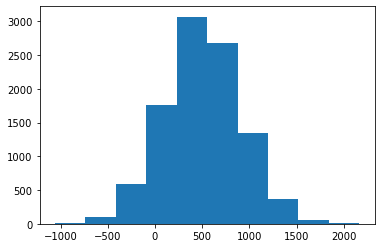

In [132]:
gene1_mu = 1000
gene1_sigma = 500

gene2_mu = 500
gene2_sigma = 500

sample_size = 3

mean_diffs = []

for trials in range(0,10000):
    s1 = np.random.normal(gene1_mu, gene1_sigma, sample_size)
    s2 = np.random.normal(gene2_mu, gene2_sigma, sample_size)
    mean_diffs.append(np.mean(s1) - np.mean(s2))
    
plt.hist(mean_diffs)

In [151]:
gene1_mu = 1000
gene1_sigma = 500

gene2_mu = 500
gene2_sigma = 500

sample_size = 10

mean_mu = 0
mean_sigma = sigma * np.sqrt(2/sample_size)

meandiffs_exp = scipy.stats.norm(loc=mean_mu,scale=mean_sigma)

meandiffs = []
meandiffs_p = []

for trials in range(0,10000):
    s1 = np.random.normal(gene1_mu, gene1_sigma, sample_size)
    s2 = np.random.normal(gene2_mu, gene2_sigma, sample_size)
    meandiff = np.mean(s2) - np.mean(s1)
    meandiffs.append(meandiff)
    meandiffs_p.append(meandiffs_exp.cdf(meandiff))
    
meandiffs = np.array(meandiffs)
meandiffs_p = np.array(meandiffs_p)




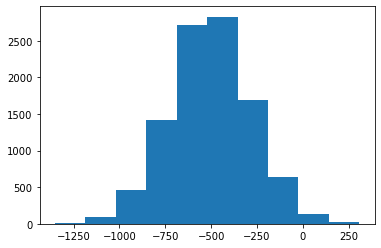

In [152]:
h = plt.hist(meandiffs)

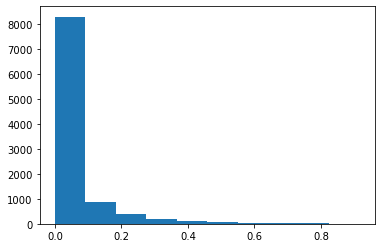

In [153]:
h = plt.hist(meandiffs_p)

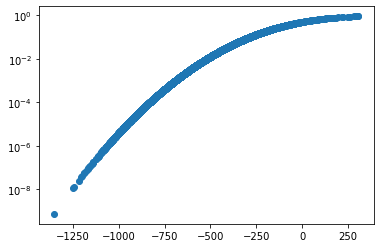

In [154]:
plt.scatter(meandiffs,meandiffs_p)
plt.yscale('log')

(array([  1.,   2.,  11.,  19.,  64., 104., 196., 347., 494., 712.]),
 array([-1351.90690083, -1285.8274193 , -1219.74793778, -1153.66845625,
        -1087.58897472, -1021.50949319,  -955.43001167,  -889.35053014,
         -823.27104861,  -757.19156708,  -691.11208555]),
 <BarContainer object of 10 artists>)

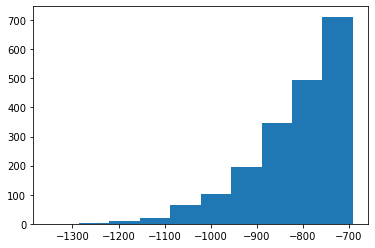

In [155]:
x = meandiffs[meandiffs_p < .001]
plt.hist(x)

In [159]:
# so how often would we call real differential expression differential expression?

for pcut in [.01,.001,.0001]:
    print ("%f %.2f" % (pcut, len(meandiffs_p[meandiffs_p < pcut]) / len(meandiffs)))

0.010000 0.47
0.001000 0.20
0.000100 0.07


In [161]:
gene1_mu = 1000
gene1_sigma = 500

gene2_mu = 500
gene2_sigma = 500

pcut = .01 / 6000

for sample_size in [3,5,10,20,50,100]:
    mean_mu = 0
    mean_sigma = sigma * np.sqrt(2/sample_size)

    meandiffs_exp = scipy.stats.norm(loc=mean_mu,scale=mean_sigma)

    meandiffs = []
    meandiffs_p = []

    for trials in range(0,10000):
        s1 = np.random.normal(gene1_mu, gene1_sigma, sample_size)
        s2 = np.random.normal(gene2_mu, gene2_sigma, sample_size)
        meandiff = np.mean(s2) - np.mean(s1)
        meandiffs.append(meandiff)
        meandiffs_p.append(meandiffs_exp.cdf(meandiff))

    meandiffs_p = np.array(meandiffs_p)
    diffcalls = len(meandiffs_p[meandiffs_p < pcut])
    diffcall_frac = len(meandiffs_p[meandiffs_p < pcut]) / len(meandiffs_p)
    print ("%d %.2f" % (sample_size,diffcall_frac))


3 0.00
5 0.00
10 0.01
20 0.06
50 0.64
100 0.99


In [162]:
# now back to real data ....

In [164]:
ye['wt_varinf'] = ye['wt_mean'].apply(lambda x: var_from_mean(x))

(1, 97589463293.42012)

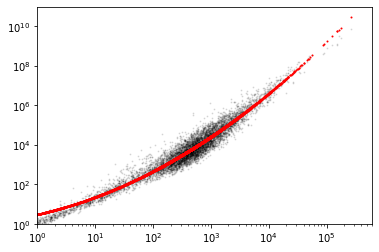

In [170]:
plt.scatter(ye['wt_mean'],ye['wt_var'],s=1,c='black',alpha=.1)
plt.scatter(ye['wt_mean'],ye['wt_varinf'],s=1,c='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,)
plt.ylim(1,)


In [185]:
def call_diffe(s1,s2,sigma):
    m1 = np.mean(s1)
    m2 = np.mean(s2)
    mean_diff = m2 - m1
    mean_sigma = sigma * np.sqrt(2/len(s1))
    mean_diff_null = scipy.stats.norm(loc=m1,scale=mean_sigma)
    raw_p = mean_diff_null.cdf(mean_diff)
    p = np.min([2*raw_p,2*(1-raw_p)])
    return p

In [201]:
ye['pdiff'] = ye.apply(lambda x: call_diffe(x[exps['wt']],x[exps['mut']],np.sqrt(x['wt_varinf'])),axis=1)

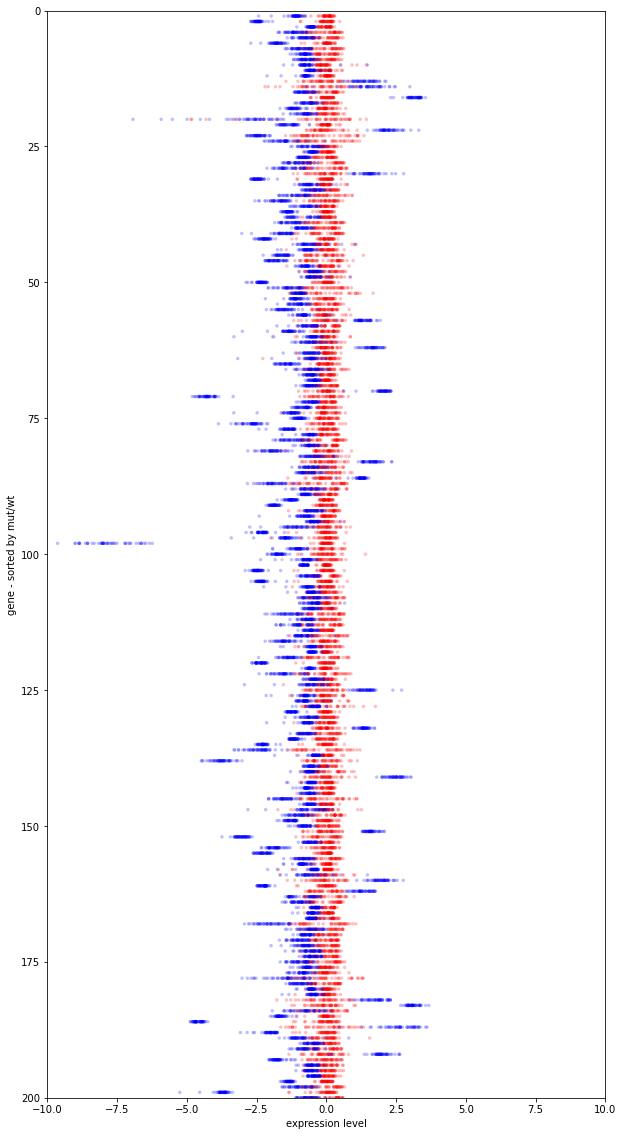

In [204]:
df = ye.copy()

for c in exps['all']:
    df[c] = np.log2(df[c]/df['wt_mean'])

mut_ind = []
mut = []
wt_ind = [] 
wt = []

row = 0
for i,r in df.sort_values('pdiff').head(200).iterrows():
    for c in exps['mut']:
        mut_ind.append(row+1)
        mut.append(r[c])
    for c in exps['wt']:
        wt_ind.append(row+1)
        wt.append(r[c])
    row = row + 1
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)

ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xlim(-10,10)
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by mut/wt")
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=.25,c='b',edgecolor='none')

In [241]:
sample_size = 3

sample = {}
sample['wt'] = list(np.random.choice(exps['wt'],sample_size))
sample['mut'] = list(np.random.choice(exps['mut'],sample_size))
sample['all'] = sample['wt'] + sample['mut']
ye_ss = ye[sample['all']].copy()

for cycles in range(0,10):
    ye_ss['all_gmean']  = gmean(ye_ss[sample['all']].replace(0,np.nan).values,axis=1)
    
    df = ye_ss[ye_ss['all_gmean'] > 10]

    for c in sample['all']:
        norm = np.median(df[c]/df['all_gmean'])
        ye_ss[c] = ye_ss[c] / norm
        
# computer row stats

for d in ['all','wt','mut']:
    ye_ss[d + '_mean']   = ye_ss[sample[d]].mean(axis=1)
    ye_ss[d + '_median'] = ye_ss[sample[d]].median(axis=1)
    ye_ss[d + '_var']    = ye_ss[sample[d]].var(axis=1)
    ye_ss[d + '_std']    = ye_ss[sample[d]].std(axis=1)
    ye_ss[d + '_gmean']  = gmean(ye_ss[sample[d]].replace(0,np.nan).values,axis=1)
    
ye_ss['wt_varinf'] = ye_ss['wt_mean'].apply(lambda x: var_from_mean(x))
ye_ss['pdiff'] = ye_ss.apply(lambda x: call_diffe(x[sample['wt']],x[sample['mut']],np.sqrt(x['wt_varinf'])),axis=1)

/Users/eisen/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


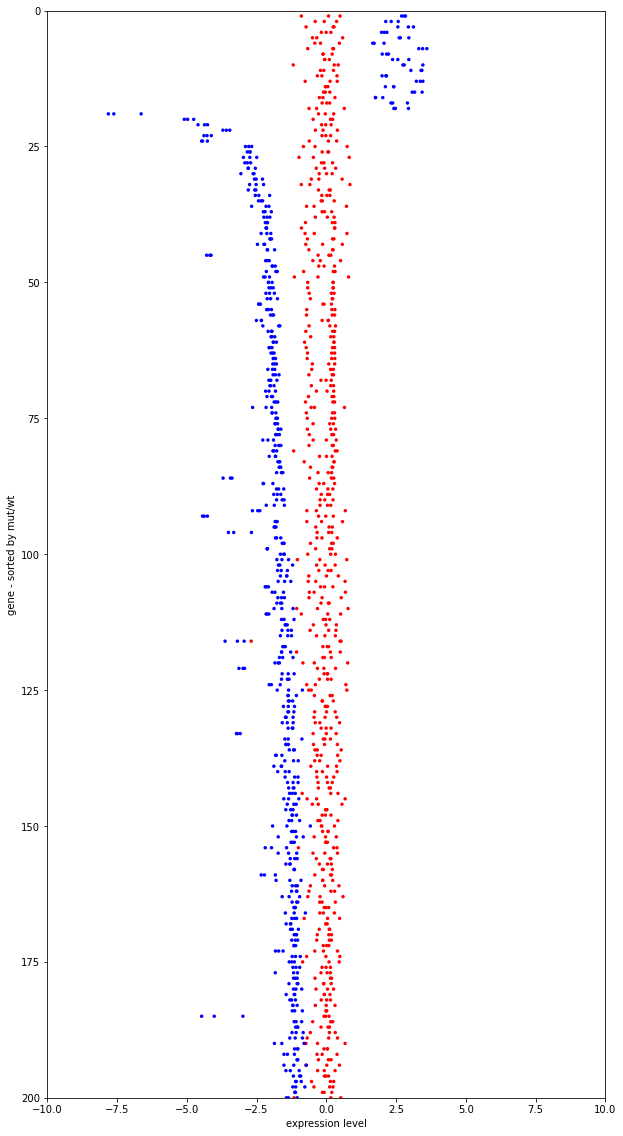

In [242]:
df = ye_ss.copy()

for c in sample['all']:
    df[c] = np.log2(df[c]/df['wt_mean'])

mut_ind = []
mut = []
wt_ind = [] 
wt = []

row = 0
for i,r in df.sort_values('pdiff').head(200).iterrows():
    for c in sample['mut']:
        mut_ind.append(row+1)
        mut.append(r[c])
    for c in sample['wt']:
        wt_ind.append(row+1)
        wt.append(r[c])
    row = row + 1
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)

ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xlim(-10,10)
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by mut/wt")
ax.scatter(wt,wt_ind,s=12,alpha=1,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=1,c='b',edgecolor='none')

In [245]:
sample_size = 3

sample = {}
ss = list(np.random.choice(exps['wt'],2*sample_size,replace=False))
sample['wt'] = ss[0:sample_size]
sample['mut'] = ss[sample_size:]
sample['all'] = sample['wt'] + sample['mut']
ye_ss = ye[sample['all']].copy()

for cycles in range(0,10):
    ye_ss['all_gmean']  = gmean(ye_ss[sample['all']].replace(0,np.nan).values,axis=1)
    
    df = ye_ss[ye_ss['all_gmean'] > 10]

    for c in sample['all']:
        norm = np.median(df[c]/df['all_gmean'])
        ye_ss[c] = ye_ss[c] / norm
        
# computer row stats

for d in ['all','wt','mut']:
    ye_ss[d + '_mean']   = ye_ss[sample[d]].mean(axis=1)
    ye_ss[d + '_median'] = ye_ss[sample[d]].median(axis=1)
    ye_ss[d + '_var']    = ye_ss[sample[d]].var(axis=1)
    ye_ss[d + '_std']    = ye_ss[sample[d]].std(axis=1)
    ye_ss[d + '_gmean']  = gmean(ye_ss[sample[d]].replace(0,np.nan).values,axis=1)
    
ye_ss['wt_varinf'] = ye_ss['wt_mean'].apply(lambda x: var_from_mean(x))
ye_ss['pdiff'] = ye_ss.apply(lambda x: call_diffe(x[sample['wt']],x[sample['mut']],np.sqrt(x['wt_varinf'])),axis=1)

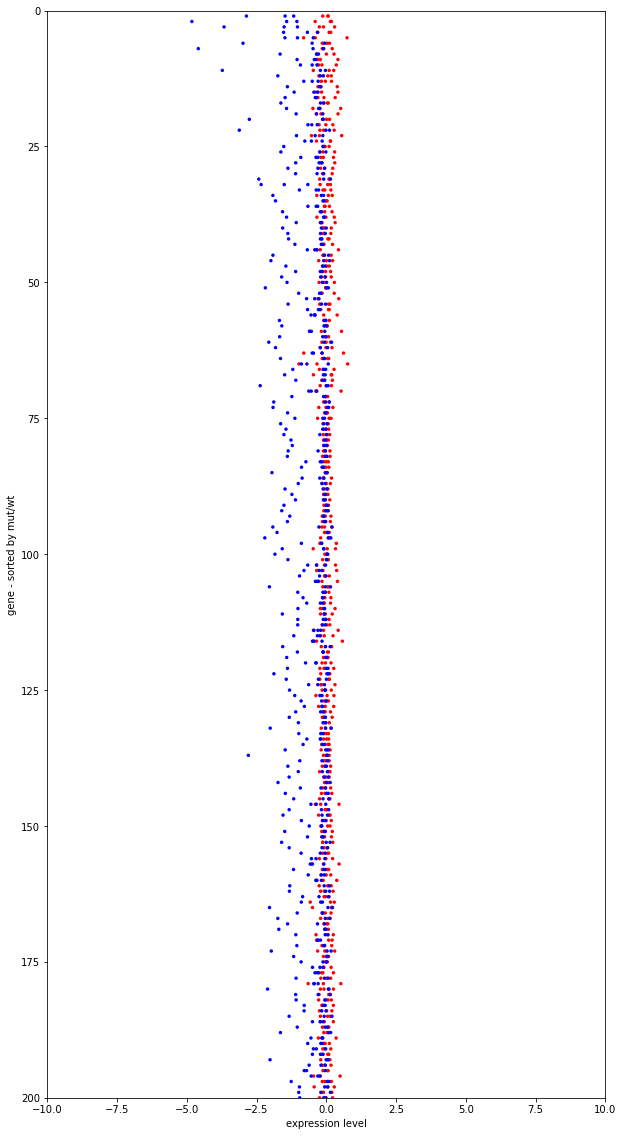

In [247]:
df = ye_ss.copy()

for c in sample['all']:
    df[c] = np.log2(df[c]/df['wt_mean'])

mut_ind = []
mut = []
wt_ind = [] 
wt = []

row = 0
for i,r in df[df.pdiff < .01/6000].sort_values('pdiff').head(200).iterrows():
    for c in sample['mut']:
        mut_ind.append(row+1)
        mut.append(r[c])
    for c in sample['wt']:
        wt_ind.append(row+1)
        wt.append(r[c])
    row = row + 1
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)

ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xlim(-10,10)
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by mut/wt")
ax.scatter(wt,wt_ind,s=12,alpha=1,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=1,c='b',edgecolor='none')